In [244]:
from astroquery.vizier import Vizier
from astropy.table import Table, join
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import astropy.units as u
from astroquery.xmatch import XMatch
from astroquery.simbad import Simbad
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

Simbad.add_votable_fields('typed_id', 'ids')
rcParams['font.family'] = 'serif'
rcParams['figure.figsize'] = 9, 6
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['legend.fontsize'] = 'large'
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize'] = 14
rcParams['figure.dpi'] = 100

## In this notebook I will be taking a look at Patten&Simon 1996 Periods found for our cluster.

I will be importing my IC2391 membership, and periods found. As well as Patten&Simon's periods found, from their paper of course.

In [11]:
# Import master table with periods, and J-K values, then add column with Calculated Masses from Stellar SEDs
master_table = Table(fits.open('master_table.fits')[1].data)

targets = ascii.read('DataInput/cluster_targets_tic.ecsv')

# Join tables with all the target information
targets.rename_column('TIC ID', 'tic id')
cross_match = join(master_table, targets, keys='tic id')
targets.rename_column('tic id', 'TIC ID')

# Import Patten Periods; process target names to query from Simbad
patten_simon = ascii.read('DataInput/Patten&Simon Periods.csv')
simbad_names = [f'{name.split()[0]} PSPC {name.split()[1]}' for name in patten_simon['\ufeffName']]

I will be using Simbad to query the Patten & Simon targets in different ID's. They use their own ID system so I will need to query their other handles, if they exist.

In [ ]:
result_table = Simbad.query_objects(simbad_names, wildcard=False, get_query_payload=False)
found_targets = np.where(result_table['COO_ERR_MAJA'].mask == 0)[0]
invalid_targets = np.where(result_table['COO_ERR_MAJA'].mask != 0)[0]

The following functions serve only to process the queried Patten & Simon IDs to match the GAIA R2 IDs.

In [237]:
def splitIDS(table, col='IDS', row=0):
    """
    return list of IDS from IDS Simbad column
    """
    return str(table[col][row], 'utf-8').split('|')

def isGaia(*args, startswith='Gaia DR2'):
    isGaiaList = []
    for ID in args:
        isGaiaList.append(ID.startswith(startswith))
    return isGaiaList

def getGaia(table, col='IDS', startswith='Gaia DR2'):
    gaiaIDList=[]
    for i in range(len(table)):
        rowIDS = splitIDS(table, row=i)
        isGaiaList = isGaia(*rowIDS)
        try:
            index = isGaiaList.index(1)
            gaiaID = rowIDS[index][9:]
        except ValueError:
            gaiaID = 'none'
        gaiaIDList.append(gaiaID)
    return gaiaIDList

Use the defined functions to now make different useful lists of the matches found, and then make a table for a useful overview.

In [199]:
pattenSimonIDS = getGaia(result_table)
matchingTICID = []
matchingPeriods = []
matchingVXRID = []
notmatchingVXRID = []
allTICIDs = []
for i in range(len(pattenSimonIDS)):
    row, = np.where(cross_match['GAIA'] == pattenSimonIDS[i])
    vxrID = simbad_names[i]
    if len(row) > 0:
        ticID = cross_match['tic id'][row[0]]
        matchingTICID.append(ticID)
        allTICIDs.append(ticID)
        matchingVXRID.append(vxrID)
        matchPeriod = (cross_match['period'][row][0], patten_simon['Period'][i])
        matchingPeriods.append(matchPeriod)
    else:
        allTICIDs.append('none')
        notmatchingVXRID.append(vxrID)
        matchingPeriods.append((np.nan, patten_simon['Period'][i]))


In [200]:
matchingTargets = Table([simbad_names, pattenSimonIDS, allTICIDs, *zip(*matchingPeriods)], 
                        names=['VXR ID','GAIA R2', 'TIC ID', 'MyPeriod', 'PattenPeriod'])
validPeriods = matchingTargets['MyPeriod'] < 14

In [256]:
matchingTargets

VXR ID,GAIA R2,TIC ID,MyPeriod,PattenPeriod
str12,str19,str9,float64,float64
VXR PSPC 12,5318545521198976000,93549309,3.6917884077844,3.86
VXR PSPC 14,5318096125872352768,none,nan,1.32
VXR PSPC 35a,5318474941990522368,none,nan,0.527
VXR PSPC 38a,5318501334573605504,none,nan,2.78
VXR PSPC 41,5318504426950057728,93832296,28.0,5.8
VXR PSPC 42a,5318503533597353856,93912428,17.759736141063048,1.81
VXR PSPC 45a,5318500303781947776,93912319,0.22319186688837062,0.223
VXR PSPC 47,5318498688873909632,93911997,0.2577362290612326,0.258
VXR PSPC 60a,none,none,nan,0.93


Now we can make a pretty plot with the matched periods to take a look at how their periods compare to our found periods. As we can see the period matches stay within 10% confidence intervals.

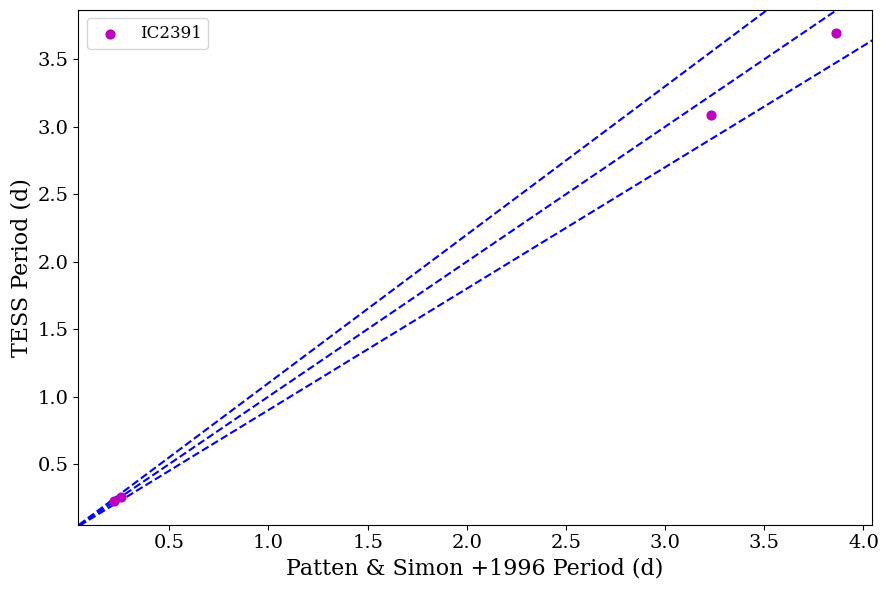

In [279]:
fig, ax = plt.subplots()
ax.scatter(matchingTargets['PattenPeriod'][validPeriods], matchingTargets['MyPeriod'][validPeriods], marker='o', c='m', s=40, label='IC2391', zorder=5)
xlims = ax.get_xlim()
ylims = ax.get_ylim()
x = np.linspace(0,20,20)
ax.plot(x,x, 'b--', label='')
ax.plot(x,x - x*.1, 'b--', label='')
ax.plot(x,x + x*.1, 'b--', label='')
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_ylabel('TESS Period (d)')
ax.set_xlabel('Patten & Simon +1996 Period (d)')
ax.legend()
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig('paper_plots/literature_comp.pdf')
# plt.savefig('paper_plots/literature_comp.eps')

Show the avaialble matches and 
describe the invalid periods, why I am not using the matches, rejecting bad periods, and use your findings in reasons why I am not detecting periods.

In 1996 Patten & Simon measured 16 periodic signals for IC2391 using ground-based telescopes. I crossmatched their catalog to ours, and I found that only 7 targets overlap in our respective memberships; there are memership differences. Our analysis was only able to retrieve four valid periods, all which correspond to the respective measured periods. Figure # shows that the Patten & Simon 1996 periods fall well within my measured periods.

Our software outputs three different types of rotation periods. We design a few threshols in our data for labeling due to the limitations that our period detection technique has, and the length of the data as well. Valid periods are those that are less that 14 days, half the length of the continous data measuring. Periods of less than 14 days will produce a light curve with two oscillations, which the Lomb Scargle periodogram has higher chance to detect, and easier for us to confirm in later vetting. Invalid periods are those more than 14 days due to the fact that the periodic signal will be less than two oscillation, (more details, why two oscillations?), which reduces the probability that our Lomb Scargle periodogram can accurately detect a period, and may induce problems in our later vetting.
Finally there are the undetected signals; these measured periods serve por as flags, indicating that the boostrap method indicates that our periodogram does not contain any strong peaks indicating a lack of a sinusoidal feature in our light curves.

Matching Targets w/ valid periods:

- VXR 12 or TIC 93549309
- VXR 45a or TIC 93912319
- VXR 47 or TIC 93911997
- VXR 72 or TIC 144752281

We have more matching targets, our algorithm did not detect a signal for two of them, and another detected period cannot be trusted since it is longer than 14 days. The following contains comments on visual vetting:

Matching targets w/ invalid periods:

- VXR 42a or TIC 93912428
    - Mag 14. 1.2d signal, lots of noise and slight trend. Bad aperture choice. Dim object and close bright neighbor.

Matching targets w/ no period detected:

- VXR 41 or TIC 93832296
    - Mag 12. Bright on CCD. Period of roughly four days; processed light curve should've detected a signal. Aperture type did a good job.
- VXR 76a or TIC 144759493
    - Mag 12. May be two overlaping objects; Two signals, 0.3d and 5d. Bad aperture choice; auto-choice didnt work with bumpy mixed signal.

